In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.graph_objects as go
import datetime



In [2]:
ticker = "o5ru.SI"
start_date = "2015-01-01"
end_date = "2025-03-16"

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [3]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,O5RU.SI,O5RU.SI,O5RU.SI,O5RU.SI,O5RU.SI,O5RU.SI
Date,,,,,,
2015-01-02,0.669482,1.422648,1.427640,1.412664,1.412664,111183
2015-01-05,0.669482,1.422648,1.432631,1.422648,1.422648,52085
2015-01-06,0.667132,1.417656,1.427640,1.417656,1.422648,194320
2015-01-07,0.674180,1.432631,1.437623,1.417656,1.417656,203335
2015-01-08,0.674180,1.432631,1.437623,1.427640,1.432631,211348
...,...,...,...,...,...,...
2025-03-10,1.240000,1.240000,1.240000,1.230000,1.240000,669800
2025-03-11,1.230000,1.230000,1.240000,1.220000,1.230000,1358400


In [4]:
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

In [5]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,0.669482,1.422648,1.427640,1.412664,1.412664,111183
2015-01-05,0.669482,1.422648,1.432631,1.422648,1.422648,52085
2015-01-06,0.667132,1.417656,1.427640,1.417656,1.422648,194320
2015-01-07,0.674180,1.432631,1.437623,1.417656,1.417656,203335
2015-01-08,0.674180,1.432631,1.437623,1.427640,1.432631,211348
...,...,...,...,...,...,...
2025-03-10,1.240000,1.240000,1.240000,1.230000,1.240000,669800
2025-03-11,1.230000,1.230000,1.240000,1.220000,1.230000,1358400
2025-03-12,1.250000,1.250000,1.260000,1.230000,1.230000,1300500


In [6]:
df = df.rename(columns={'Close': 'GT'})
df

Price,Adj Close,GT,High,Low,Open,Volume
Date,,,,,,
2015-01-02,0.669482,1.422648,1.427640,1.412664,1.412664,111183
2015-01-05,0.669482,1.422648,1.432631,1.422648,1.422648,52085
2015-01-06,0.667132,1.417656,1.427640,1.417656,1.422648,194320
2015-01-07,0.674180,1.432631,1.437623,1.417656,1.417656,203335
2015-01-08,0.674180,1.432631,1.437623,1.427640,1.432631,211348
...,...,...,...,...,...,...
2025-03-10,1.240000,1.240000,1.240000,1.230000,1.240000,669800
2025-03-11,1.230000,1.230000,1.240000,1.220000,1.230000,1358400
2025-03-12,1.250000,1.250000,1.260000,1.230000,1.230000,1300500


In [7]:
print(df['GT'].dtypes)
print(df['GT'].describe())


float64
count    2561.000000
mean        1.351449
std         0.089352
min         0.928465
25%         1.290000
50%         1.362747
75%         1.412664
max         1.597359
Name: GT, dtype: float64


### Visualize Data

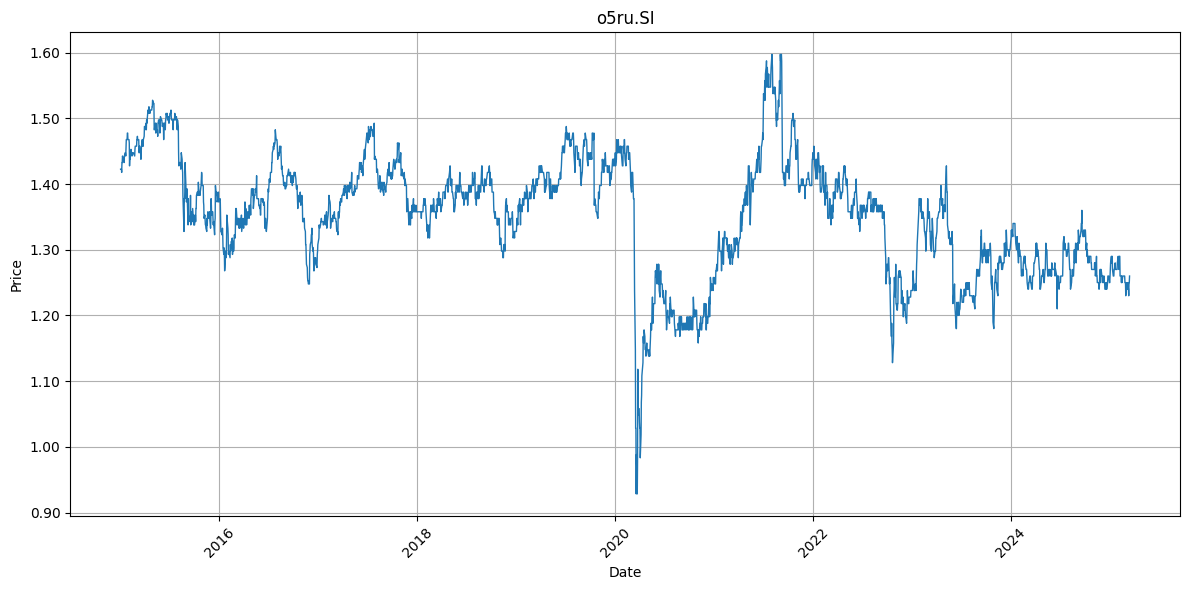

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['GT'], linewidth=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('o5ru.SI')

# Format y-axis ticks to 2 decimal places
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# Automatically reduce number of y-axis ticks (matplotlib does it smartly)
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=8))  # Limit to ~8 y-axis ticks

# Rotate x-axis ticks to avoid overlap
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



## Standardize data 

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(df['GT'].values.reshape(-1,1))
scaled_prices

array([[0.73880614],
       [0.73880614],
       [0.73134306],
       ...,
       [0.48069653],
       [0.48069653],
       [0.49564657]], shape=(2561, 1))

## Construct datasets

In [10]:
MOVING_WINDOW = 60
all_x, all_y = [], []
for i in range(len(scaled_prices) - MOVING_WINDOW):
    all_x.append(scaled_prices[i:i+MOVING_WINDOW]) #first 60 price
    all_y.append(scaled_prices[i+MOVING_WINDOW]) #61st price

all_x = np.array(all_x)
all_y = np.array(all_y)

In [11]:
all_x.shape, all_y.shape

((2501, 60, 1), (2501, 1))

## Split dataset

In [12]:
DS_SPLIT = 0.8

train_ds_size = round(all_x.shape[0] * DS_SPLIT)
train_x, train_y = all_x[:train_ds_size], all_y[:train_ds_size]
test_x, test_y = all_x[train_ds_size:], all_y[train_ds_size:]

In [13]:
train_x.shape

(2001, 60, 1)

In [14]:
train_y.shape

(2001, 1)

In [15]:
test_x.shape

(500, 60, 1)

In [16]:
test_y.shape

(500, 1)

## Construct Model

In [ ]:
'''
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_x.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()
'''

c:\Users\Jesus\anaconda3\envs\lstm\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''
model.compile(optimizer='adam', loss='mean_squared_error')
'''

## Train Model

In [20]:
'''
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(train_x, train_y,
          validation_split=0.2,
          callbacks=[callback],
          epochs=200)
model.save('o5ru.keras')
'''

"\ncallback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)\nmodel.fit(train_x, train_y,\n          validation_split=0.2,\n          callbacks=[callback],\n          epochs=200)\nmodel.save('o5ru.keras')\n"

In [17]:
model = load_model('o5ru.keras')
preds = model.predict(test_x)
preds

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[0.5991247 ],
       [0.6240096 ],
       [0.5918932 ],
       [0.5667149 ],
       [0.54851973],
       [0.5458364 ],
       [0.5355637 ],
       [0.5459414 ],
       [0.55072933],
       [0.55171454],
       [0.57552207],
       [0.58269477],
       [0.5946727 ],
       [0.62139016],
       [0.6281683 ],
       [0.6275755 ],
       [0.63857734],
       [0.6416329 ],
       [0.64179236],
       [0.6416235 ],
       [0.6669224 ],
       [0.67396474],
       [0.69936335],
       [0.6920216 ],
       [0.6620109 ],
       [0.6541549 ],
       [0.6673725 ],
       [0.6332171 ],
       [0.6370412 ],
       [0.62756044],
       [0.651202  ],
       [0.65791166],
       [0.644774  ],
       [0.67854553],
       [0.70016783],
       [0.7413898 ],
       [0.7100336 ],
       [0.6857665 ],
       [0.6811984 ],
       [0.6166889 ],
       [0.5896805 ],
       [0.57609785],
       [0.57712775],
       [0.59289074],
       [0.584854  ],
       [0.5682761 ],
       [0.5758449 ],
       [0.578

In [18]:
preds = scaler.inverse_transform(preds) #convert back to original scale
preds

array([[1.3292159],
       [1.3458612],
       [1.3243787],
       [1.3075371],
       [1.2953665],
       [1.2935717],
       [1.2867002],
       [1.2936419],
       [1.2968445],
       [1.2975035],
       [1.3134282],
       [1.318226 ],
       [1.3262379],
       [1.344109 ],
       [1.348643 ],
       [1.3482465],
       [1.3556056],
       [1.3576494],
       [1.3577559],
       [1.357643 ],
       [1.3745652],
       [1.3792759],
       [1.3962649],
       [1.3913541],
       [1.3712801],
       [1.3660253],
       [1.3748664],
       [1.35202  ],
       [1.354578 ],
       [1.3482363],
       [1.36405  ],
       [1.3685381],
       [1.3597504],
       [1.38234  ],
       [1.396803 ],
       [1.4243761],
       [1.4034022],
       [1.38717  ],
       [1.3841144],
       [1.3409644],
       [1.3228987],
       [1.3138133],
       [1.3145022],
       [1.325046 ],
       [1.3196703],
       [1.3085815],
       [1.3136442],
       [1.3157012],
       [1.3075529],
       [1.304822 ],


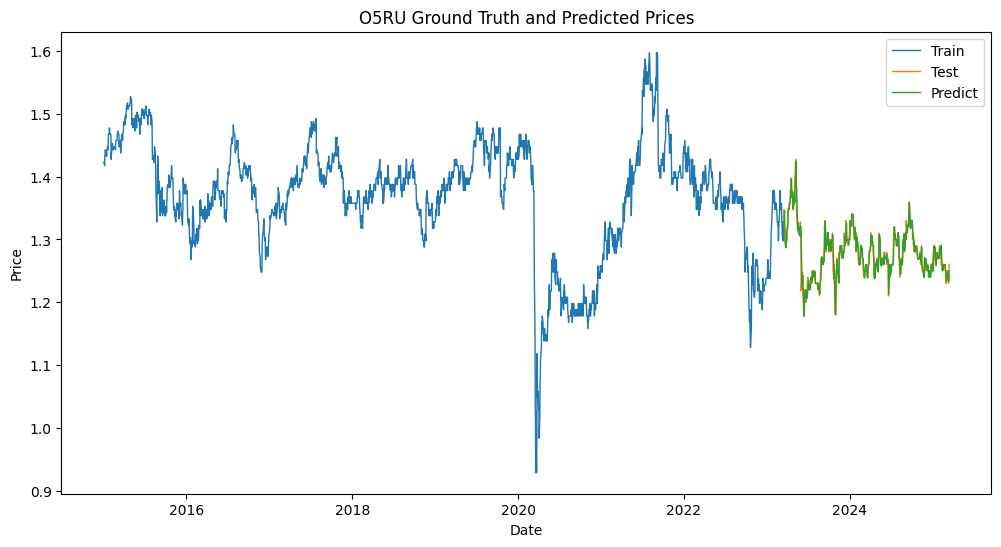

In [19]:
train_df = df[:train_ds_size+MOVING_WINDOW]
test_df = df[train_ds_size+MOVING_WINDOW:]
test_df = test_df.assign(Predict = preds)

plt.figure(figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train_df["GT"], linewidth=1)
plt.plot(test_df["GT"], linewidth=1)
plt.plot(test_df["Predict"], linewidth=1)
plt.legend(["Train", "Test", "Predict"])
plt.title('O5RU Ground Truth and Predicted Prices')
plt.show()

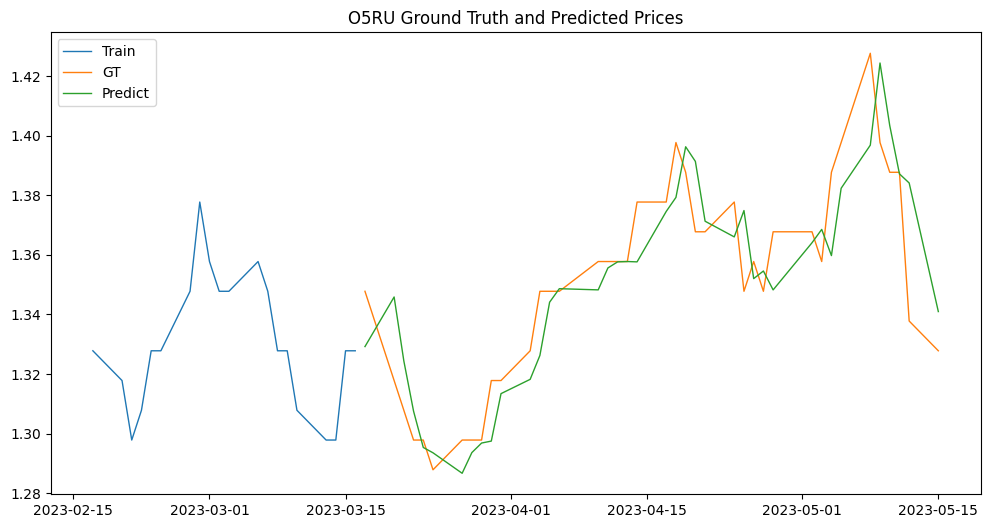

In [20]:
#zoom in
plt.figure(figsize=(12, 6))
plt.plot(train_df["GT"][-20:], linewidth=1)
plt.plot(test_df["GT"][:40], linewidth=1)
plt.plot(test_df["Predict"][:40], linewidth=1)
plt.legend(["Train", "GT", "Predict"])
plt.title('O5RU Ground Truth and Predicted Prices')
plt.show()

In [21]:
train_df["GT"][-20:]

Date
2023-02-17    1.327805
2023-02-20    1.317821
2023-02-21    1.297854
2023-02-22    1.307838
2023-02-23    1.327805
2023-02-24    1.327805
2023-02-27    1.347772
2023-02-28    1.377722
2023-03-01    1.357755
2023-03-02    1.347772
2023-03-03    1.347772
2023-03-06    1.357755
2023-03-07    1.347772
2023-03-08    1.327805
2023-03-09    1.327805
2023-03-10    1.307838
2023-03-13    1.297854
2023-03-14    1.297854
2023-03-15    1.327805
2023-03-16    1.327805
Name: GT, dtype: float64

In [ ]:

y_true = test_df["GT"]
y_pred = test_df["Predict"]

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-squared (R²): {r2:.6f}")

Mean Absolute Error (MAE): 0.0098
Mean Squared Error (MSE): 0.0002
Root Mean Squared Error (RMSE): 0.0134
R-squared (R²): 0.8786


In [27]:
test_df

Price,Adj Close,GT,High,Low,Open,Volume,Predict
Date,,,,,,,
2023-03-17,1.160498,1.347772,1.347772,1.317821,1.327805,1951620,1.329216
2023-03-20,1.134709,1.317821,1.347772,1.307838,1.337788,754645,1.345861
2023-03-21,1.126113,1.307838,1.327805,1.307838,1.317821,2485902,1.324379
2023-03-22,1.117516,1.297854,1.317821,1.297854,1.307838,1203986,1.307537
2023-03-23,1.117516,1.297854,1.307838,1.297854,1.297854,780287,1.295367
...,...,...,...,...,...,...,...
2025-03-10,1.240000,1.240000,1.240000,1.230000,1.240000,669800,1.247298
2025-03-11,1.230000,1.230000,1.240000,1.220000,1.230000,1358400,1.242827
2025-03-12,1.250000,1.250000,1.260000,1.230000,1.230000,1300500,1.232916


In [25]:
test_df['GT_tmr'] = test_df['GT'].shift(1)
test_df.dropna(subset=['GT_tmr'], inplace=True)

test_df

Price,Adj Close,GT,High,Low,Open,Volume,Predict,GT_tmr
Date,,,,,,,,
2023-03-20,1.134709,1.317821,1.347772,1.307838,1.337788,754645,1.345861,1.347772
2023-03-21,1.126113,1.307838,1.327805,1.307838,1.317821,2485902,1.324379,1.317821
2023-03-22,1.117516,1.297854,1.317821,1.297854,1.307838,1203986,1.307537,1.307838
2023-03-23,1.117516,1.297854,1.307838,1.297854,1.297854,780287,1.295367,1.297854
2023-03-24,1.108920,1.287871,1.317821,1.287871,1.307838,1506986,1.293572,1.297854
...,...,...,...,...,...,...,...,...
2025-03-07,1.250000,1.250000,1.250000,1.230000,1.240000,890600,1.239932,1.240000
2025-03-10,1.240000,1.240000,1.240000,1.230000,1.240000,669800,1.247298,1.250000
2025-03-11,1.230000,1.230000,1.240000,1.220000,1.230000,1358400,1.242827,1.240000


In [27]:
results = {}

# Loop through the prediction columns
for col in ["Predict", "GT_tmr"]:
    y_true = test_df["GT"]
    y_pred = test_df[col]

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    results[col] = [mae, mse, rmse, r2]

# Convert to DataFrame for a clean display
metrics_df = pd.DataFrame(results, index=["MAE", "MSE", "RMSE", "R2"])
print(metrics_df)

       Predict    GT_tmr
MAE   0.009786  0.009311
MSE   0.000178  0.000180
RMSE  0.013352  0.013429
R2    0.878380  0.876970


## Next-Day Predictive Trading Strategy

In [28]:
# Parameters
initial_capital = 10000
percent_of_equity = 0.8
stop_loss = 0.1  # 10% stop-loss
capital = initial_capital
position = None  
entry_price = 0
equity = initial_capital  
trade_log = []  

# Iterate through the DataFrame
for i in range(1, len(test_df) - 1): 
    current_price = test_df['GT'].iloc[i] 
    next_predicted_price = test_df['Predict'].iloc[i + 1] 
    date = test_df.index[i]  
    # Check if a position is active
    if position == 'long':
        # Check for stop-loss or trend reversal
        if current_price <= entry_price * (1 - stop_loss) or next_predicted_price < current_price:
            # Close long position
            profit = (current_price - entry_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({'Date': date, 'Action': 'Close Long', 'Price': current_price, 'Profit': profit, 'Equity': equity})
            position = None

    elif position == 'short':
        # Check for stop-loss or trend reversal
        if current_price >= entry_price * (1 + stop_loss) or next_predicted_price > current_price:
            # Close short position
            profit = (entry_price - current_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({'Date': date, 'Action': 'Close Short', 'Price': current_price, 'Profit': profit, 'Equity': equity})
            position = None

    # If no position is active, check for entry signals
    if position is None:
        if next_predicted_price > current_price:
            # Open long position
            entry_price = current_price
            position = 'long'
            trade_log.append({'Date': date, 'Action': 'Open Long', 'Price': current_price, 'Profit': 0, 'Equity': equity})
        elif next_predicted_price < current_price:
            # Open short position
            entry_price = current_price
            position = 'short'
            trade_log.append({'Date': date, 'Action': 'Open Short', 'Price': current_price, 'Profit': 0, 'Equity': equity})


trade_log_df = pd.DataFrame(trade_log)

# Calculate metrics
closed_trades = trade_log_df[trade_log_df['Action'].str.contains('Close')]  
gross_profit = closed_trades[closed_trades['Profit'] > 0]['Profit'].sum()  
gross_loss = closed_trades[closed_trades['Profit'] < 0]['Profit'].sum() 
net_profit = gross_profit + gross_loss  

# Buy-and-Hold Return
initial_price = test_df['GT'].iloc[0]  
final_price = test_df['GT'].iloc[-1]  
buy_and_hold_return = ((final_price - initial_price) / initial_price) * 100 

# Display results
print(f"Gross Profit: ${gross_profit:.2f}")
print(f"Gross Loss: ${gross_loss:.2f}")
print(f"Net Profit: ${net_profit:.2f}")
print(f"Buy-and-Hold Return: {buy_and_hold_return:.2f}%")

# Display the trade log
print(trade_log_df)

# Final equity
print(f"Final Equity: ${equity:.2f}")

Gross Profit: $12981.72
Gross Loss: $-7072.11
Net Profit: $5909.62
Buy-and-Hold Return: -6.51%
          Date       Action     Price     Profit        Equity
0   2023-03-20    Open Long  1.317821   0.000000  10000.000000
1   2023-03-21   Close Long  1.307838 -60.603451   9939.396549
2   2023-03-21   Open Short  1.307838   0.000000   9939.396549
3   2023-03-31  Close Short  1.317821 -61.066053   9878.330496
4   2023-03-31    Open Long  1.317821   0.000000   9878.330496
..         ...          ...       ...        ...           ...
538 2025-03-06   Open Short  1.240000   0.000000  15845.100905
539 2025-03-10  Close Short  1.240000   0.000000  15845.100905
540 2025-03-10    Open Long  1.240000   0.000000  15845.100905
541 2025-03-12   Close Long  1.250000  64.516067  15909.616972
542 2025-03-12   Open Short  1.250000   0.000000  15909.616972

[543 rows x 5 columns]
Final Equity: $15909.62


In [29]:
# Extract series
dates = test_df.index
gt = test_df['GT']
predict = test_df['Predict']

# Separate long/short entries & exits from the trade log
entry_long = trade_log_df[trade_log_df['Action'].str.contains("Open Long")]
entry_short = trade_log_df[trade_log_df['Action'].str.contains("Open Short")]
exit_long = trade_log_df[trade_log_df['Action'].str.contains("Close Long")]
exit_short = trade_log_df[trade_log_df['Action'].str.contains("Close Short")]

# Create the interactive plot
fig = go.Figure()

# Ground truth price line
fig.add_trace(go.Scatter(x=dates, y=gt, mode='lines', name='GT (Actual)', line=dict(color='blue')))

# Predicted price line
fig.add_trace(go.Scatter(x=dates, y=predict, mode='lines', name='Predicted', line=dict(color='orange')))

# Entry Long signals
fig.add_trace(go.Scatter(
    x=entry_long['Date'], y=entry_long['Price'],
    mode='markers',
    name='Buy Signal',
    marker=dict(symbol='triangle-up', size=10, color='green')
))

# Entry Short signals
fig.add_trace(go.Scatter(
    x=entry_short['Date'], y=entry_short['Price'],
    mode='markers',
    name='Sell Signal',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

# Exit Long signals
fig.add_trace(go.Scatter(
    x=exit_long['Date'], y=exit_long['Price'],
    mode='markers',
    name='Exit Long',
    marker=dict(symbol='x', size=9, color='lime')
))

# Exit Short signals
fig.add_trace(go.Scatter(
    x=exit_short['Date'], y=exit_short['Price'],
    mode='markers',
    name='Exit Short',
    marker=dict(symbol='x', size=9, color='purple')
))

# Layout settings
fig.update_layout(
    title='Next-Day Predictive Trading Strategy',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    template='plotly_white',
    hovermode='closest'
)

fig.show()


## Append news analysis result

In [30]:
sentiment_df = pd.read_csv('../news_analysis_code/o5ru_news_data.csv', usecols=['date', 'sentiment', 'sentiment_score'])
sentiment_df.columns = ['Date', 'Sentiment', 'Sentiment Score']
sentiment_df.head()

,Date,Sentiment,Sentiment Score
0,2025-03-18,positive,0.671989
1,2025-03-18,neutral,0.941522
2,2025-02-19,positive,0.952833
3,2024-11-14,positive,0.913844
4,2024-12-10,neutral,0.928776


In [31]:
# rearrange the date
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

# Keep only the row with the highest sentiment score
sentiment_df = sentiment_df.loc[sentiment_df.groupby('Date')['Sentiment Score'].idxmax()].reset_index(drop=True)

sentiment_df.head()

,Date,Sentiment,Sentiment Score
0,2017-02-09,negative,0.952163
1,2018-11-21,neutral,0.921193
2,2019-05-31,neutral,0.741253
3,2019-06-11,neutral,0.948913
4,2019-07-25,negative,0.854871


In [32]:
sentiment_df['Sentiment'] = sentiment_df['Sentiment'].replace({
    'neutral': 0,
    'positive': 1,
    'negative': -1
})

sentiment_df.head()

C:\Users\Jesus\AppData\Local\Temp\ipykernel_23412\1101630648.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,Date,Sentiment,Sentiment Score
0,2017-02-09,-1,0.952163
1,2018-11-21,0,0.921193
2,2019-05-31,0,0.741253
3,2019-06-11,0,0.948913
4,2019-07-25,-1,0.854871


In [33]:
sentiment_df.dtypes

Date               datetime64[ns]
Sentiment                   int64
Sentiment Score           float64
dtype: object

In [34]:
sentiment_df = sentiment_df.set_index('Date')

In [35]:
#keep only matching dates
merged_df = pd.merge(test_df, sentiment_df, on='Date', how='left')
merged_df.head()

,Adj Close,GT,High,Low,Open,Volume,Predict,Sentiment,Sentiment Score
Date,,,,,,,,,
2023-03-17,1.160498,1.347772,1.347772,1.317821,1.327805,1951620,1.329216,NaN,NaN
2023-03-20,1.134709,1.317821,1.347772,1.307838,1.337788,754645,1.345861,NaN,NaN
2023-03-21,1.126113,1.307838,1.327805,1.307838,1.317821,2485902,1.324379,NaN,NaN
2023-03-22,1.117516,1.297854,1.317821,1.297854,1.307838,1203986,1.307537,NaN,NaN
2023-03-23,1.117516,1.297854,1.307838,1.297854,1.297854,780287,1.295367,NaN,NaN


In [36]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2023-03-17 to 2025-03-14
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Adj Close        500 non-null    float64
 1   GT               500 non-null    float64
 2   High             500 non-null    float64
 3   Low              500 non-null    float64
 4   Open             500 non-null    float64
 5   Volume           500 non-null    int64  
 6   Predict          500 non-null    float32
 7   Sentiment        28 non-null     float64
 8   Sentiment Score  28 non-null     float64
dtypes: float32(1), float64(7), int64(1)
memory usage: 37.1 KB


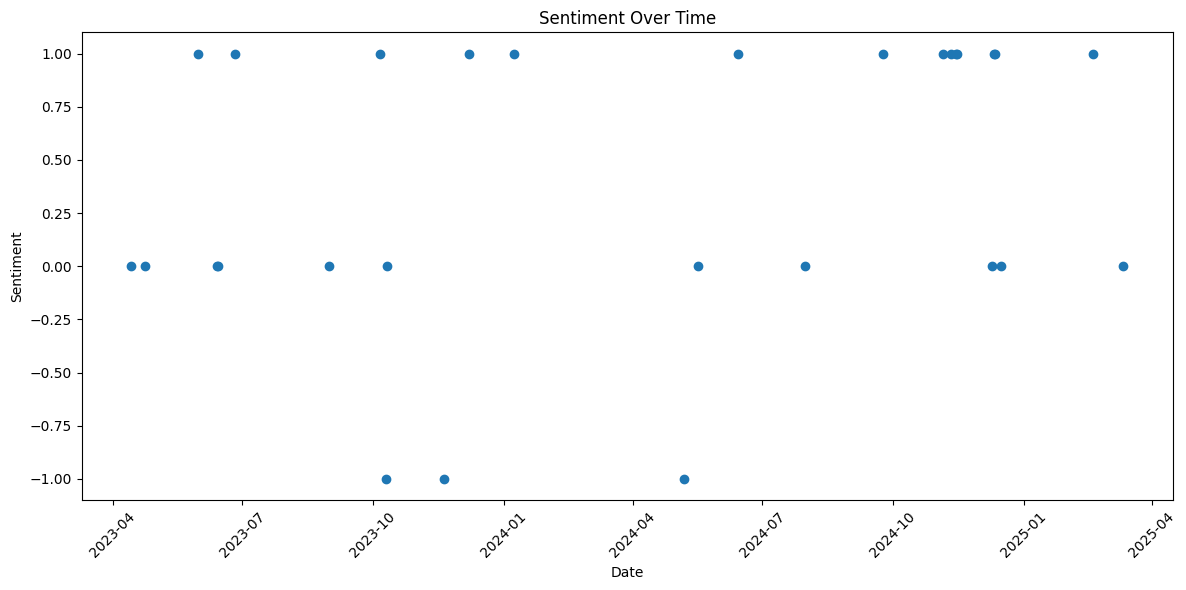

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Sentiment'], marker='o', linestyle='None')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Sentiment Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

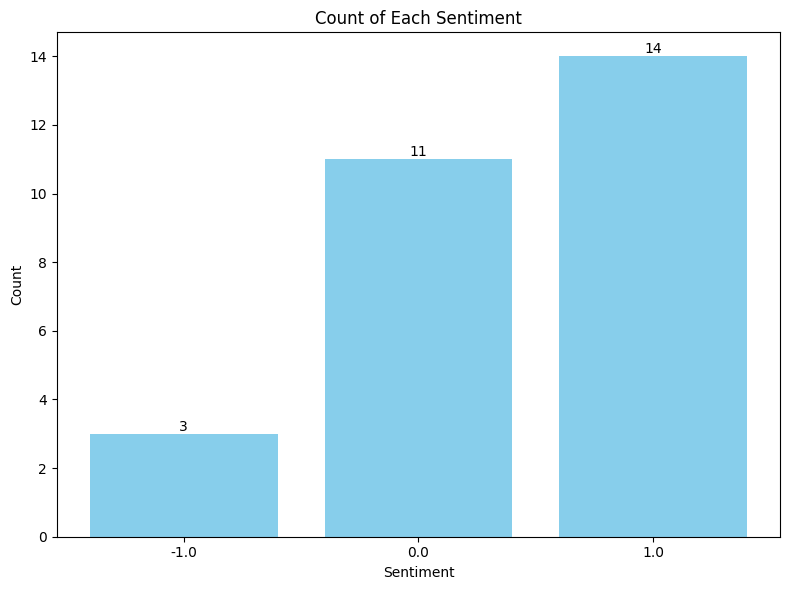

In [38]:
sentiment_counts = merged_df['Sentiment'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
bars = plt.bar(sentiment_counts.index.astype(str), sentiment_counts.values, color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Each Sentiment')

# Add the count above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)),
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [39]:
nan_count = merged_df['Sentiment'].isna().sum()
nan_count

np.int64(472)

In [40]:
merged_df

,Adj Close,GT,High,Low,Open,Volume,Predict,Sentiment,Sentiment Score
Date,,,,,,,,,
2023-03-17,1.160498,1.347772,1.347772,1.317821,1.327805,1951620,1.329216,NaN,NaN
2023-03-20,1.134709,1.317821,1.347772,1.307838,1.337788,754645,1.345861,NaN,NaN
2023-03-21,1.126113,1.307838,1.327805,1.307838,1.317821,2485902,1.324379,NaN,NaN
2023-03-22,1.117516,1.297854,1.317821,1.297854,1.307838,1203986,1.307537,NaN,NaN
2023-03-23,1.117516,1.297854,1.307838,1.297854,1.297854,780287,1.295367,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-03-10,1.240000,1.240000,1.240000,1.230000,1.240000,669800,1.247298,NaN,NaN
2025-03-11,1.230000,1.230000,1.240000,1.220000,1.230000,1358400,1.242827,NaN,NaN
2025-03-12,1.250000,1.250000,1.260000,1.230000,1.230000,1300500,1.232916,0.0,0.905784


## News-Driven Next-Day Predictive Trading Strategy

In [41]:
initial_capital = 10000
percent_of_equity = 0.8
stop_loss = 0.2

capital = initial_capital
equity = initial_capital
trade_log = []
position = None
entry_price = None

i = 0
while i < len(test_df):
    # Forced exit condition on March 14, 2025
    if merged_df.index[i] == pd.Timestamp("2025-03-14"):
        if position is not None:
            exec_price = test_df['GT'].iloc[i]
            if position == 'long':
                profit = (exec_price - entry_price) * (capital * percent_of_equity / entry_price)
                trade_log.append({
                    'Date': test_df.index[i],
                    'Action': 'Forced Exit Long',
                    'Price': exec_price,
                    'Profit': profit,
                    'Equity': equity
                })
            elif position == 'short':
                profit = (entry_price - exec_price) * (capital * percent_of_equity / entry_price)
                trade_log.append({
                    'Date': test_df.index[i],
                    'Action': 'Forced Exit Short',
                    'Price': exec_price,
                    'Profit': profit,
                    'Equity': equity
                })
        break

    signal_price = merged_df['GT'].iloc[i]
    predicted_price = merged_df['Predict'].iloc[i]

    # Entry signals (same day)
    if position is None:
        if predicted_price > signal_price and (merged_df['Sentiment'].iloc[i] in [1, 0] or pd.isna(merged_df['Sentiment'].iloc[i])):
            position = 'long'
            entry_price = merged_df['GT'].iloc[i]
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Enter Long',
                'Price': entry_price,
                'Profit': 0,
                'Equity': equity
            })
        elif predicted_price < signal_price and (merged_df['Sentiment'].iloc[i] in [-1, 0] or pd.isna(merged_df['Sentiment'].iloc[i])):
            position = 'short'
            entry_price = merged_df['GT'].iloc[i]
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Enter Short',
                'Price': entry_price,
                'Profit': 0,
                'Equity': equity
            })
        i += 1
        continue

    # Exit conditions (same day)
    current_gt = merged_df['GT'].iloc[i]
    if position == 'long':
        if predicted_price < current_gt or current_gt <= entry_price * (1 - stop_loss) or merged_df['Sentiment'].iloc[i] == -1:
            profit = (current_gt - entry_price) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Exit Long',
                'Price': current_gt,
                'Profit': profit,
                'Equity': equity
            })
            position = None
    elif position == 'short':
        if predicted_price > current_gt or current_gt >= entry_price * (1 + stop_loss) or merged_df['Sentiment'].iloc[i] == 1:
            profit = (entry_price - current_gt) * (capital * percent_of_equity / entry_price)
            equity += profit
            trade_log.append({
                'Date': merged_df.index[i],
                'Action': 'Exit Short',
                'Price': current_gt,
                'Profit': profit,
                'Equity': equity
            })
            position = None
    i += 1

# Create DataFrame from trade log
trade_log_df = pd.DataFrame(trade_log)

# Summary metrics
closed_trades = trade_log_df[trade_log_df['Action'].str.contains('Exit')]
gross_profit = closed_trades[closed_trades['Profit'] > 0]['Profit'].sum()
gross_loss = closed_trades[closed_trades['Profit'] < 0]['Profit'].sum()
net_profit = gross_profit + gross_loss
buy_and_hold_return = ((test_df['GT'].iloc[-1] - test_df['GT'].iloc[0]) / test_df['GT'].iloc[0]) * 100

print(f"\n--- Strategy Summary ---")
print(f"Gross Profit: ${gross_profit:.2f}")
print(f"Gross Loss: ${gross_loss:.2f}")
print(f"Net Profit: ${net_profit:.2f}")
print(f"Buy-and-Hold Return: {buy_and_hold_return:.2f}%")
print(f"Final Equity: ${equity:.2f}")
print("\nTrade Log:")
print(trade_log_df)



--- Strategy Summary ---
Gross Profit: $7235.21
Gross Loss: $-4385.81
Net Profit: $2849.40
Buy-and-Hold Return: -6.51%
Final Equity: $12913.40

Trade Log:
          Date             Action     Price      Profit        Equity
0   2023-03-17        Enter Short  1.347772    0.000000  10000.000000
1   2023-03-20         Exit Short  1.317821  177.780671  10177.780671
2   2023-03-21         Enter Long  1.307838    0.000000  10177.780671
3   2023-03-23          Exit Long  1.297854  -61.071886  10116.708785
4   2023-03-24         Enter Long  1.287871    0.000000  10116.708785
..         ...                ...       ...         ...           ...
327 2025-03-07          Exit Long  1.250000   64.516067  12848.886852
328 2025-03-10         Enter Long  1.240000    0.000000  12848.886852
329 2025-03-12          Exit Long  1.250000   64.516067  12913.402919
330 2025-03-13        Enter Short  1.250000    0.000000  12913.402919
331 2025-03-14  Forced Exit Short  1.260000  -63.999939  12913.402919

[33

In [42]:
# Extract series
dates = merged_df.index
gt = merged_df['GT']
predict = merged_df['Predict']

# Separate long/short entries & exits from the trade log
entry_long = trade_log_df[trade_log_df['Action'].str.contains("Enter Long")]
entry_short = trade_log_df[trade_log_df['Action'].str.contains("Enter Short")]
exit_long = trade_log_df[trade_log_df['Action'].str.contains("Exit Long")]
exit_short = trade_log_df[trade_log_df['Action'].str.contains("Exit Short")]

# Create the interactive plot
fig = go.Figure()

# Ground truth price line
fig.add_trace(go.Scatter(x=dates, y=gt, mode='lines', name='GT (Actual)', line=dict(color='blue')))

# Predicted price line
fig.add_trace(go.Scatter(x=dates, y=predict, mode='lines', name='Predicted', line=dict(color='orange')))

# Entry Long signals
fig.add_trace(go.Scatter(
    x=entry_long['Date'], y=entry_long['Price'],
    mode='markers',
    name='Buy Signal',
    marker=dict(symbol='triangle-up', size=10, color='green')
))

# Entry Short signals
fig.add_trace(go.Scatter(
    x=entry_short['Date'], y=entry_short['Price'],
    mode='markers',
    name='Sell Signal',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

# Exit Long signals
fig.add_trace(go.Scatter(
    x=exit_long['Date'], y=exit_long['Price'],
    mode='markers',
    name='Exit Long',
    marker=dict(symbol='x', size=9, color='lime')
))

# Exit Short signals
fig.add_trace(go.Scatter(
    x=exit_short['Date'], y=exit_short['Price'],
    mode='markers',
    name='Exit Short',
    marker=dict(symbol='x', size=9, color='purple')
))

# Layout settings
fig.update_layout(
    title='News-Driven Next-Day Predictive Trading Strategy',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    template='plotly_white',
    hovermode='closest'
)

fig.show()
